In [17]:
import sys

sys.path.append("../..")
from cge_modeling import Variable, Parameter, Equation, CGEModel
import numpy as np

# Model Declaration 

A CGE model is comprised of three components:

1. Variables: symbolic objects that represent model quantities that will vary endogenously in your model.
2. Parameters: symbolic objects that represent model quantities that will vary exogenously in your model (or not at all!)
3. Equations: A mathematical description of your model economy.

To create a model, one first must write down all the variables and parameters that will go into the model.

## Model Setup

In this first simple model, we consider an economy with a single household and a single firm. The household has fixed endowments of labor and capital, which it sells to the firm for wages and rents, respectively. The firm uses these to produce a single consumption good, which it then sells back to the household. There is no government and no investment. The structure of the economy is shown in the following graph:

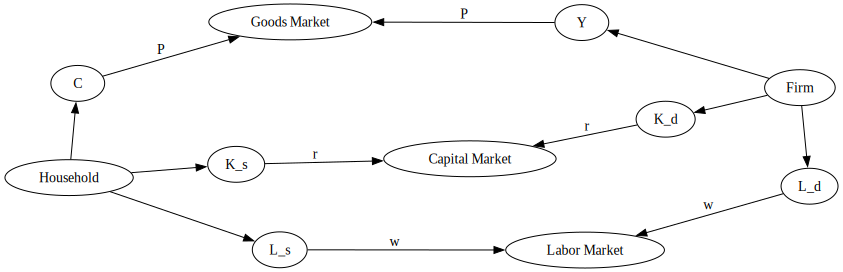

In [2]:
import graphviz as gr


def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(
        graph_attr={"rankdir": graph_direction, "ratio": "0.25"},
        engine="neato",
    )

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


nodes = ["K", "L", "Y", "C", "Household", "Firm"]
edges = [
    ("Household", "K_s"),
    ("Household", "L_s"),
    ("Household", "C"),
    ("Firm", "Y"),
    ("Firm", "K_d"),
    ("Firm", "L_d"),
    ("K_d", "Capital Market"),
    ("L_d", "Labor Market"),
    ("K_s", "Capital Market"),
    ("L_s", "Labor Market"),
    ("C", "Goods Market"),
    ("Y", "Goods Market"),
]
edge_props = {
    ("K_d", "Capital Market"): {"label": "r"},
    ("K_s", "Capital Market"): {"label": "r"},
    ("L_d", "Labor Market"): {"label": "w"},
    ("L_s", "Labor Market"): {"label": "w"},
    ("C", "Goods Market"): {"label": "P"},
    ("Y", "Goods Market"): {"label": "P"},
}
draw_graph(edges, edge_props=edge_props, graph_direction="LR")

Given this structure, the economy will be comprised of the following equations:

$$
\begin{align}
    Y &= C & \text{Goods market clearing} \\
    K_d &= K_s & \text{Capital market clearing} \\
    L_d &= L_s & \text{Labor market clearing} \\
    Y &= f(K_d, L_d) & \text{Production function} \\
    \frac{r}{P} &= \frac{\partial f \left (K_d, L_d \right )}{\partial K_d} & \text{Firm demand for capital} \\
    \frac{w}{P} &= \frac{\partial f \left (K_d, L_d \right )}{\partial L_d} & \text{Firm demand for labor} \\
    PC &= rK_s + wL_s + \Pi & \text{Household budget constraint}
\end{align}
$$

Since we are an endowment economy, we take $K_s$ and $L_s$ as given -- they are thus parameters. The variables are $Y$, $C$, $K_d$, $L_d$, $w$, $r$, and $P$. $\Pi$, the profits of the firm, we set to zero to eliminate. So we have 7 variables and 7 unknowns.

### Underdetermination

The system above looks square, but actually it's not! The household budget constraint is equivalent to the goods market clearning condition. To see this, you have to know that the equations for the firm's factor demand are based on the zero profit condtion. Suppose we don't eliminate $\Pi$, and instead use the identity:

$$\Pi = P Y - r K_d - w L_d$$

Substituting this into the household budget constraint, we obtain:

$$PC = r K_s + w L_s + P Y - r K_d - w L_d $$

From the factor clearing conditions we have $K_d = K_s$ and $L_d = L_s$, so we can make these substitutions:

$$\begin{align}
PC &= r K_s - r K_s + w L_s - w L_s + PY \\
PC &= PY \\
C &= Y
\end{align}
$$

We recovered the market clearing condition from the other equations! This shows that although we wrote down 7 equations, we actually only have 6 equations worth of information.

### Walras' Law and Choice of Numeraire

It's surprising that we only have 6 independent equations, given that we have 7 variables. But actually we only have 6 variables. This is because of Walras' law. The law says that, given perfect competiton and flexible prices in all markets (which we've assumed), the sum of the values of excess demands (or supplies) must be zero. This is an additional constraint on the economy, which has the effect of pinning down the price of the last good, assuming we know the prices of all other goods. In our case, if we know values of $r$ and $w$, we are *not* free to choose a value for $P$. 

As a result, one of our prices is not actually a variable at all. We are required to choose a numeraire -- a price that all other prices are measured by. The choice of numeraire is the modeler's. I will choose $w$, the wage level, to be the numeraire. As a result, all prices will be expressed in hourly wages.

Conceptually, we think of $w$ as a parameter now (which we will fix to be 1 -- since any numeraire value implies a valid price vector, we might as well choose the easiest possible value). Now we have 6 variables are 7 equations, 6 of which are independent. 

### Squaring up the system

Now we just need to make the system square. We have two choices. First, we could remove one of the redundant equations (either the household budget constraint or the goods market clearing conditions). Alternatively, we can add a dummy "residual" variable, which we set to zero. This second choice is popular because it adds a consistency check to model simulations. This residual should always be zero, at all valid equlibria. 

We will add a residual term, $\varepsilon$, to the market clearing condition. So our system now becomes:

### The Final System

Finally, we need to specify a production function. We can use Cobb-Douglas, so $Y = f(K_d, L_d) = AK_d^\alpha L_d^{1-\alpha}$.

The system then becomes:

$$
\begin{align}
    Y &= C + \varepsilon & \text{Goods market clearing} \\
    K_d &= K_s & \text{Capital market clearing} \\
    L_d &= L_s & \text{Labor market clearing} \\
    Y &= AK_d^\alpha L_d^{1-\alpha} & \text{Production function} \\
    K_d &= \alpha Y \frac{P}{r} & \text{Firm demand for capital} \\
    L_d &= (1 - \alpha) Y \frac{P}{w} & \text{Firm demand for labor} \\
    PC &= rK_s + wL_s + \Pi & \text{Household budget constraint}
\end{align}
$$

Where $Y$, $C$, $K_d$, $L_d$, $r$, $P$, and $\varepsilon$ are variables. $A$, $\alpha$, $L_s$, $K_s$, and $w$ are parameters.

We have 7 variables and 7 independent equations (since the market clearing and budget constraint now vary by $\varepsilon$!), and we are ready to proceed. 

## Declare Variables

First, we make a list of variables using the `Variable` class. In their simplest form, variables have a `name` and a `description`. We can optionally also specify a `latex_name` for pretty printing.

In [3]:
variables = [
    Variable("Y", description="Total output"),
    Variable("C", description="Household constumption"),
    Variable("K_d", description="Firm demand for capital"),
    Variable("L_d", description="Firm demand for labor"),
    Variable("r", description="Rental rate of capital"),
    Variable("P", description="Price of consumption goods"),
    Variable("resid", latex_name="\\varepsilon", description="Walrasian residual"),
]

## Declare Parameters

`Parameter`s are exactly the same as `Variable`s, except that they are treated differently inside the model.

In [4]:
parameters = [
    Parameter("A", description="Total factor productivity"),
    Parameter("alpha", description="Share of capital in production"),
    Parameter("L_s", description="Household endowment of labor"),
    Parameter("K_s", description="Household endowment of capital"),
    Parameter("w", description="Wage level"),
]

## Declare equations

`Equation`s also have a name, but instead of a description, you need to provide a string form of the equation. 

In [5]:
equations = [
    Equation("Production function", "Y = A * K_d ** alpha * L_d ** (1 - alpha)"),
    Equation("Firm capital demand function", "K_d = alpha * Y * P / r"),
    Equation("Firm labor demand function", "L_d = (1 - alpha) * Y * P / w"),
    Equation("Household budget constraint", "P * C = r * K_s + w * L_s"),
    Equation("Labor market clearing", "L_s = L_d"),
    Equation("Capital market clearing", "K_s = K_d"),
    Equation("Goods market clearing", "Y = C + resid"),
]

# Create a model

With these these lists, we are ready to create a CGEModel

In [6]:
mod = CGEModel(
    variables=variables, parameters=parameters, equations=equations, backend="pytensor"
)

Beginning compilation using pytensor backend using C (FAST_RUN) mode
Compiling model with ['root', 'minimize', 'euler'] functions
Compiling model equations into pytensor graph
Compiling CGE equations into C function
Compiling Jacobian equations into C function
Computing sum of squared errors
Computing SSE gradient
Computing SSE Jacobian
Compiling SSE functions (sse, gradient, jacobian) into C function


Once the model is built, we can look at the equations

In [7]:
mod.equation_table()

<IPython.core.display.Latex object>

As well as the parameters and variables

In [12]:
mod.summary("variables")

<IPython.core.display.Latex object>

In [14]:
mod.summary("parameters")

<IPython.core.display.Latex object>

Or, if you prefer, everything together

In [15]:
mod.summary()

<IPython.core.display.Latex object>

# Data and Calibration

To actually run policy experiments, you have to first find a non-trivial model equlibrium. To check for an equlibrium, you can use the `model.check_for_equlibrium` method. It expects a dictionary containing all model variables and parameters, and checks whether all provided model equations are equal to zero

In [18]:
all_objects = mod.variable_names + mod.parameter_names
random_initial_point = dict(
    zip(all_objects, np.random.normal(size=len(all_objects)) ** 2)
)
mod.check_for_equilibrium(random_initial_point)

Equilibrium not found. Total squared error: 29.926224


Equation                               Residual
Production function                   -0.548869
Firm capital demand function           3.727394
Firm labor demand function             0.095799
Household budget constraint           -0.601396
Labor market clearing                  0.081894
Capital market clearing               -3.571485
Goods market clearing                 -1.611967


For data, we will use a (fake!) balanced SAM. We exploit the fact that the SAM is balanced to "calibrate" the model, choosing parameter values that lead to the data observed in the SAM. Calibration is unique to each model, so `cge_modeling` currently can't do that for you. What it can do is help you with some consistency checks. We need to:

1. Write a python function that takes the model, plus all required initial data from the SAM
2. Inside the function, make sure every parameter and variable is given a value
3. return `model.check_calibration()`

`model.check_calibration()` specifically looks at the local namespace, so it's important that it is called from within a function.

## Load Data

In [25]:
import pandas as pd

sam = pd.read_csv(
    "../data/simple_rbc_data.csv", index_col=[0, 1], header=[0, 1]
).fillna(0)
sam

Factor         Institution Production Activities
                        Labor Capital   Household       Firm       Firm
Factor      Labor         0.0     0.0         0.0        0.0     7000.0
            Capital       0.0     0.0         0.0        0.0     3000.0
Institution Household  7000.0  3000.0         0.0        0.0        0.0
Production  Firm          0.0     0.0     10000.0        0.0        0.0
Activities  Firm          0.0     0.0         0.0    10000.0        0.0

First we can double check that this is a properly balanced SAM by checking that the sum of the rows is equal to the sum of the columns

In [26]:
sam.sum(axis=1) == sam.sum(axis=0)

Factor       Labor        True
             Capital      True
Institution  Household    True
Production   Firm         True
Activities   Firm         True
dtype: bool

For bigger SAMs its not realistic to look row by row, so we can use `.all()`

In [27]:
(sam.sum(axis=1) == sam.sum(axis=0)).all()

True

Next, we extract the required initial values. In this case we actually know basically everything, but let's try to work with the minimum set: $Y$, $K_d$, $L_d$.

In [30]:
initial_values = {
    "Y": sam.loc[("Activities", "Firm"), ("Production", "Firm")],
    "K_d": sam.loc[("Factor", "Capital"), ("Activities", "Firm")],
    "L_d": sam.loc[("Factor", "Labor"), ("Activities", "Firm")],
}

In [31]:
initial_values

{'Y': 10000.0, 'K_d': 3000.0, 'L_d': 7000.0}

Now we make a Python function that expects these initial values:

In [74]:
import inspect


def check_shape(data, name, mod):
    obj = mod.get(name)
    dims = obj.dims
    shape = tuple([len(mod.coords[i]) for i in dims])
    data = np.array(data)

    if data.shape in [(1,), ()] and shape == ():
        data = data.squeeze()
    if data.shape != shape:
        print(f"{name} has shape {data.shape}, expected {shape}")
    return data


def finalize_calibration(mod):
    d = {}
    caller_locals = inspect.currentframe().f_back.f_locals

    for obj in sorted(mod.variables) + sorted(mod.parameters):
        if obj.name != "_" and obj.name in caller_locals:
            data = caller_locals[obj.name]
            if isinstance(data, (pd.DataFrame, pd.Series)):
                data = data.values
            d[obj.name] = check_shape(data, obj.name, mod)
        else:
            print(f"{obj.name} not found in model variables")
    return d

In [75]:
def calibrate_model(mod, *, Y, K_d, L_d):
    # Normalize prices
    r = 1.0
    w = 1.0
    P = 1.0

    # Calibrate parameters
    alpha = r * K_d / (r * K_d + w * L_d)
    A = Y / K_d**alpha / L_d ** (1 - alpha)

    # Market clearing conditions
    K_s = K_d
    L_s = L_d
    C = Y
    resid = Y - C

    return finalize_calibration(mod)

In [76]:
calibrate_model(mod, **initial_values)

{'C': array(10000.),
 'K_d': array(3000.),
 'L_d': array(7000.),
 'P': array(1.),
 'Y': array(10000.),
 'r': array(1.),
 'resid': array(0.),
 'A': array(1.84202278),
 'K_s': array(3000.),
 'L_s': array(7000.),
 'alpha': array(0.3),
 'w': array(1.)}